# <center> Identify Customer Segments- Machine Learning </center>

## Table of Contents

1. <a href="#Intro">Introduction</a>
2. <a href="#Prepa"> Prepare the datasets</a>
3. <a href="#Trans">Feature Transformation</a>
    * <a href="#Scale"> 3.1 - Apply Feature Scaling </a>
    * <a href="#Dimen"> 3.2 - Perform Dimensionality Reduction </a>
    * <a href="#Inter"> 3.3 - Interpret Principal Components </a>
4. <a href="#Clust">Clustering </a>
    * <a href="#Gener"> 4.1 - Apply Clustering to General Population </a>
    * <a href="#Custo"> 4.2 - Apply All Steps to the Customer Data </a>
    * <a href="#Compa"> 4.3 - Compare Customer Data to Demographics Data </a>
5. <a href="#Concl">Conclusion </a>

<a id = 'Intro'></a>
## 1 - Introduction

Based on the [data cleansing](https://github.com/omarkhater/identify-customer-segments/blob/main/Identify_Customer_Segments_Exploration.ipynb)  notebook, we now have a solid understanding of the data under consideration. _In this notebook_, **First of all**, we clean the data using the pipeline developed toward the end of the cleansing notebook. **Then**, we proceed with the _feature transformation_ as well as the _clustering parts_ of this project. **Finally**, _we conclude_ this analysis by applying the whole pipeline( i.e., cleansing and ML) for an another dataset containing the same demographic data about specific customers in a trial of analysing the common patterns associated with the general population. Hopefully, this process will lead to a better understanding of the customer behaviours in shadow of the available data about general population. 

**P.S. It should be noted that running this whole notebook might take several minutes.** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import do_pca, scree_plot, pca_results, map_weights,fit_kmeans, clean_data, color_map
from sklearn.cluster import KMeans

<a id = 'Prepa'></a>
### 2 -  Prepare the datasets

The complete data cleaning procedure and detailed justification for each step is given on the [Data Cleansing notebook](http://localhost:8888/notebooks/Identify_Customer_Segments_Exploration.ipynb). To simplify this notebook, we just peform the data cleansing pipeline on general population dataframe. 

In [40]:
original_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
original_feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
original_feat_info.index = original_feat_info.attribute
original_feat_info.drop('attribute', axis = 1, inplace = True)
azdias_cleaned, OH_Columns = clean_data(original_azdias, original_feat_info.copy())
azdias_cleaned.head()

Data cleansing pipeline...
	1-Replacing missing values per column with Nan...
		Replacing done
	2-Removing the outliars columns and rows...
		Removing the outliars columns and rows done
	3-Feature Engineering...
		Feature Engineering done
	4-Removing missing values...
		Removing missing values done.
Cleansing pipeline done


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_6A,OST_WEST_KZ_W,OST_WEST_KZ_O,movement,Waelth,LifeStage
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,1
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,4
2,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,3
3,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5,4
4,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,2


<a id = 'Trans'></a>
## 3 - Feature Transformation

<a id = 'Scale'></a>
### 3.1 -  Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. In this substep, we perform a standard scaling so that all the features have a mean of 0 and a standard deviation of 1. 

In [3]:
# Apply feature scaling to the general population demographics data.
Sclaer_obj = StandardScaler()
azdias2 = pd.DataFrame(Sclaer_obj.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)

### Discussion : Apply Feature Scaling

We applied standard scaling so that all the features have a mean of 0 and a standard deviation of 1.

<a id = 'Dimen'></a>
### 3.2 - Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques. Below is a summary of the upcoming procedure:

- Using sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class, we apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed).
- Checking out the ratio of variance explained by each principal component as well as the cumulative variance explained. In addition, we plot the cumulative values. Based on the findings, we select a value for the number of transformed features to retain for the clustering part.
- Finally, we re-fit a PCA instance to perform the decided-on transformation on the selected number of the features.

In [4]:
# Apply PCA to the whole scaled data.
pca, X_pca = do_pca(n_components = azdias_cleaned.shape[1], data = azdias2)

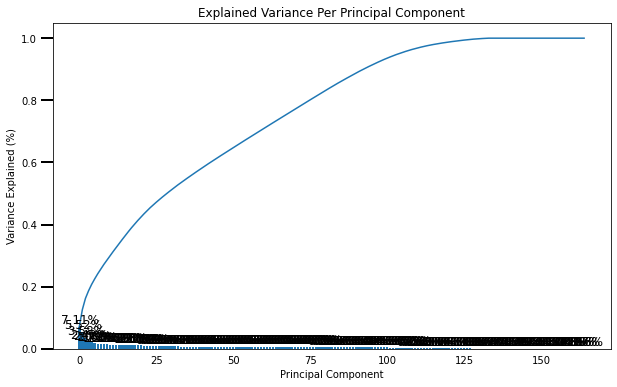

In [5]:
# Investigate the variance accounted for by each principal component.
vals,cumvals = scree_plot(pca)

It is evident from the figure above that all principle components explain closely spaced variance ratios. This indicates the diversity of the data so that no principle component dominates the importance space. 

Having completed the PCA analysis using all the features, we should retain specific number of components to facilitate the upcoming clustering as possible. Thus, we need to keep the number of the features which results in explaining specific threshold of the original data's variance.  

In [6]:
# Re-apply PCA to the data while selecting for number of components to retain.
threshold_PCA_retain = .8
comp_to_retain = np.where(cumvals <= threshold_PCA_retain)[0][-1]
pca, X_pca = do_pca(n_components = comp_to_retain, data = azdias_cleaned)
FinalPCAresults = pca_results(azdias_cleaned, pca)

In [7]:
FinalPCAresults.shape

(74, 166)

In [8]:
FinalPCAresults.head()

,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_6A,OST_WEST_KZ_W,OST_WEST_KZ_O,movement,Waelth,LifeStage
Dimension 1,0.0712,-0.2325,-0.2221,0.2446,-0.2117,0.1783,0.1807,0.0740,0.0529,-0.1158,...,0.0358,0.0481,0.0447,0.0408,-0.0076,0.0250,-0.0250,-0.1270,0.1215,-0.1017
Dimension 2,0.0552,0.1180,-0.1061,-0.0832,0.0999,-0.1043,-0.1324,0.2051,-0.0139,0.1099,...,0.0277,0.0523,0.0536,0.0566,0.0383,0.0574,-0.0574,0.0170,0.2075,-0.0894
Dimension 3,0.0359,0.0321,0.1176,-0.0666,0.0648,-0.1706,-0.0687,-0.0265,-0.0149,0.1055,...,0.0028,0.0225,0.0365,0.0232,0.0059,0.0109,-0.0109,0.0453,0.0611,-0.0354
Dimension 4,0.0243,-0.0112,-0.0206,0.0002,0.0235,-0.0802,0.0220,0.0212,-0.0208,0.0143,...,0.0299,0.0072,0.0235,0.0278,0.0093,-0.0595,0.0595,0.0719,0.0192,-0.0189
Dimension 5,0.0207,0.0376,-0.0021,-0.0043,-0.0101,0.1114,-0.1508,0.0616,-0.0073,-0.0194,...,0.0516,0.0571,0.0103,-0.0071,-0.0089,0.2867,-0.2867,-0.0490,0.1698,-0.0439


### Discussion: Perform Dimensionality Reduction

So, selecting to retain the principal components that explain `80%` of the variance in the dataset kept only `74` columns of the cleaned dataset. 

<a id = 'Inter'></a>
### 3.3 -  Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

To recap in a nutshell, each principal component is a unit vector that points in the direction of the highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we wrote a function `map_weights` to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [9]:
# Map weights for the first 3 principal component to the corresponding feature names and then print them 
weights1 = map_weights(FinalPCAresults, 0)
weights2 = map_weights(FinalPCAresults, 1)
weights3 = map_weights(FinalPCAresults, 2)
d1 = pd.DataFrame(np.array(weights1), index = weights1.index, columns = ['Component 1']).T
d2 = pd.DataFrame(np.array(weights2), index = weights2.index, columns = ['Component 2']).T
d3 = pd.DataFrame(np.array(weights3), index = weights3.index, columns = ['Component 3']).T

In [10]:
d1

,FINANZ_SPARER,SEMIO_PFLICHT,SEMIO_REL,SEMIO_TRADV,FINANZTYP_1.0,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,SEMIO_RAT,LP_STATUS_FEIN_3.0,LP_STATUS_GROB_1.0,...,LP_STATUS_FEIN_7.0,RETOURTYP_BK_S,FINANZTYP_5.0,movement,ZABEOTYP_1.0,SEMIO_LUST,SEMIO_ERL,FINANZ_VORSORGER,FINANZ_MINIMALIST,ALTERSKATEGORIE_GROB
Component 1,0.2446,0.2091,0.209,0.1984,0.1837,0.1807,0.1783,0.1746,0.1612,0.1537,...,-0.1033,-0.1158,-0.122,-0.127,-0.1397,-0.1615,-0.1665,-0.2117,-0.2221,-0.2325


In [11]:
d2

,Waelth,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,LP_STATUS_FEIN_2.0,LP_STATUS_GROB_1.0,EWDICHTE,ZABEOTYP_1.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_FEIN_5.0,ARBEIT,...,SEMIO_TRADV,FINANZTYP_2.0,SEMIO_KULT,SEMIO_REL,FINANZ_UNAUFFAELLIGER,INNENSTADT,KONSUMNAEHE,ZABEOTYP_5.0,ANZ_PERSONEN,ONLINE_AFFINITAET
Component 2,0.2075,0.2051,0.2001,0.1846,0.184,0.1654,0.1612,0.1558,0.1558,0.1382,...,-0.1162,-0.1198,-0.1199,-0.1293,-0.1324,-0.1362,-0.1445,-0.1487,-0.1511,-0.1897


In [12]:
d3

,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_6.0,SHOPPER_TYP_3.0,SEMIO_REL,FINANZ_MINIMALIST,RETOURTYP_BK_S,ZABEOTYP_5.0,...,LP_STATUS_FEIN_3.0,ZABEOTYP_6.0,FINANZTYP_1.0,SHOPPER_TYP_0.0,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM
Component 3,0.3363,0.2804,0.2767,0.2662,0.1479,0.1347,0.1291,0.1176,0.1055,0.0999,...,-0.0797,-0.0797,-0.1053,-0.1094,-0.1706,-0.1733,-0.2122,-0.2799,-0.3103,-0.3346


_In addition_, we wrote a function to visualize the weights' **top important features** using a color map with a _divergent color palette_. This palette is chosen since the weights are,naturally, zero-centered. So, more extreme colors *alawys* mean strong correlation between the feature and the principal component. <u>Furthermore</u>, the color determines the *type* of the correlation whether it a positive or negative. To make the visualization more readable we sorted the values keeping the sign associated with each feature as well as parameterizing number of the components to be displayed.  

Dimension 1 , Explained Variance = 0.0712


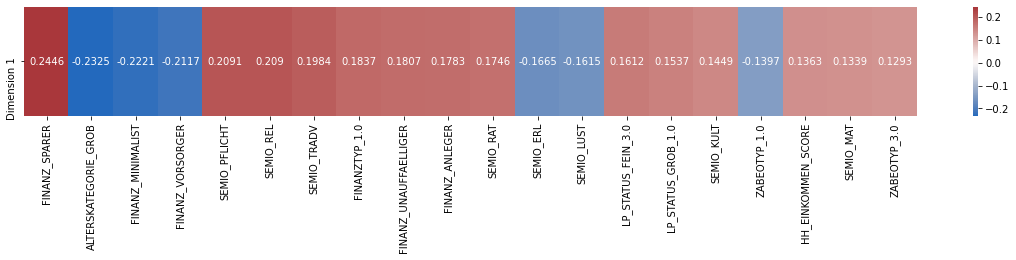

Dimension 2 , Explained Variance = 0.0552


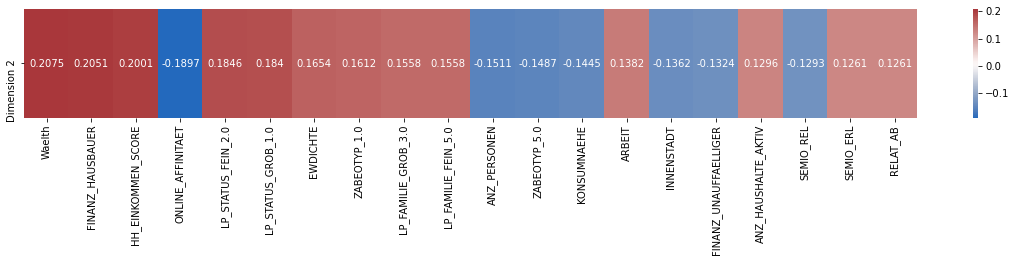

Dimension 3 , Explained Variance = 0.0359


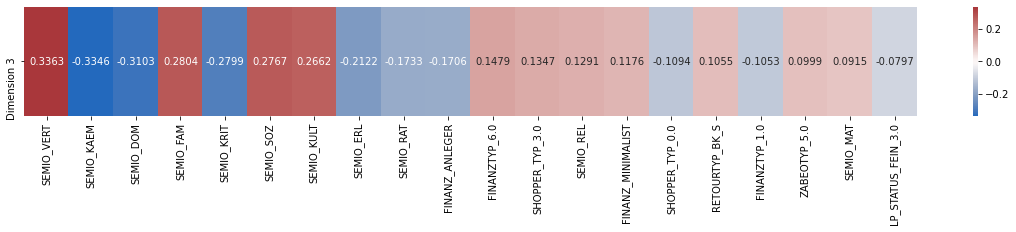

In [13]:
d1_sorted = color_map(FinalPCAresults, row = 'Dimension 1', num_features = 20)
d2_sorted = color_map(FinalPCAresults, row = 'Dimension 2', num_features = 20)
d3_sorted = color_map(FinalPCAresults, row = 'Dimension 3', num_features = 20)

In [14]:
original_feat_info.loc[d1.iloc[:, [1,-1]].columns,:].information_level, original_feat_info.loc[d2.iloc[:, [1,-1]].columns,:].information_level, original_feat_info.loc[d3.iloc[:, [1,-1]].columns,:].information_level
# To do: Add visualization to display percentage of each information level category contribution
# to top 20 features for the first 3 components

(SEMIO_PFLICHT           person
 ALTERSKATEGORIE_GROB    person
 Name: information_level, dtype: object,
 FINANZ_HAUSBAUER         person
 ONLINE_AFFINITAET    region_rr1
 Name: information_level, dtype: object,
 SEMIO_FAM     person
 SEMIO_KAEM    person
 Name: information_level, dtype: object)

### Discussion: Interpret Principal Components

**_As an interesting point_**, 5 out of 6 most important features contributing to first three PCA components (i.e., positive, negative correlations) are from `person-level` features. This observation can further be exteneded to explore the contribution of each level category to top `K` components easily. 

<a id = 'Clust'></a>
## 4 -  Clustering

<a id = 'Gener'></a>
### 4.1 - Apply Clustering to General Population

Having assessed ,cleaned, scaled and transformed the demographics data, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

A summary of the upcoming procedure is given below
-  Performing k-means clustering on the PCA-transformed data using sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).
- Computing the average difference from each point to its assigned cluster's center. 
- Performing the above two steps for a number of different cluster counts so, we can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Using this fact, we select a final number of clusters in which to group the data.
- Having selected a final number of clusters to use, we re-fit a KMeans instance to perform the clustering operation.

In [15]:
centers_1 = np.arange(10,30,3)
scores_1 = []
for k in centers_1:
    print('k = {}...'.format(k))
    model = KMeans(n_clusters = k)
    model.fit(X_pca)
    scores_1.append(np.abs(model.score(X_pca)))

k = 10...
k = 13...
k = 16...
k = 19...
k = 22...
k = 25...
k = 28...


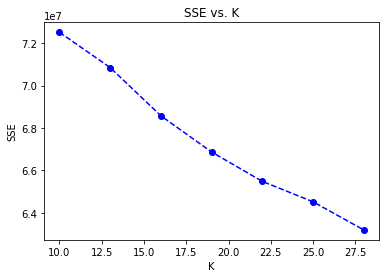

In [16]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(centers_1, scores_1, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

### Discussion: Apply Clustering to General Population

As evident from the figure, selecting `K = 21` provide the point which adding more clusters don't add too much value. Thus, we proceed with total number of `21` clusters. 

In [17]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_best = 21
labels,Kmeans_obj = fit_kmeans(X_pca, k_best) #fit kmeans to get the labels

In [18]:
(unique_general, counts_general) = np.unique(labels, return_counts=True)
general_labels_per = counts_general/labels.shape[0] *100

<a id = 'Custo'></a>
### 4.2 -  Apply All Steps to the Customer Data

Now we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. In the last step of the project, we will interpret how the general population fits apply to the customer data.

A summary of the upcoming procedure is given below:
- Loading the customer data
- Applying the same cleansing pipeline done with the general population data
- Applying the same feature transformation steps (i.e., scaling and pca) using the objects obtained previosuly. 
- Finally, clustering the tranformed data using the same clustering object. 

In [31]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [41]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned, _ = clean_data(customers,original_feat_info.copy())

Data cleansing pipeline...
	1-Replacing missing values per column with Nan...
		Replacing done
	2-Removing the outliars columns and rows...
		Removing the outliars columns and rows done
	3-Feature Engineering...
		Feature Engineering done
	4-Removing missing values...
		Removing missing values done.
Cleansing pipeline done


In [42]:
customers_scaled = pd.DataFrame(Sclaer_obj.transform(customers_cleaned), columns = customers_cleaned.columns)

In [43]:
customers_transformed = pca.transform(customers_scaled)
customers_labels = Kmeans_obj.predict(customers_transformed)

In [44]:
(unique, counts) = np.unique(customers_labels, return_counts=True)
customers_labels_per = counts/customers_labels.shape[0] *100

<a id = 'Compa'></a>
### 4.3 - Compare Customer Data to Demographics Data

At this point, we have clustered the data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

As usual, a summary of the upcoming procedure in this sub-step is provided below:

- Computing the proportion of data points in each cluster for the general population and the customer data. 
- Answers to the questions : Which cluster or clusters are (overrepresented - underrepresented) in the customer dataset compared to the general population? What does it mean in terms of the original features in the given dataset? 

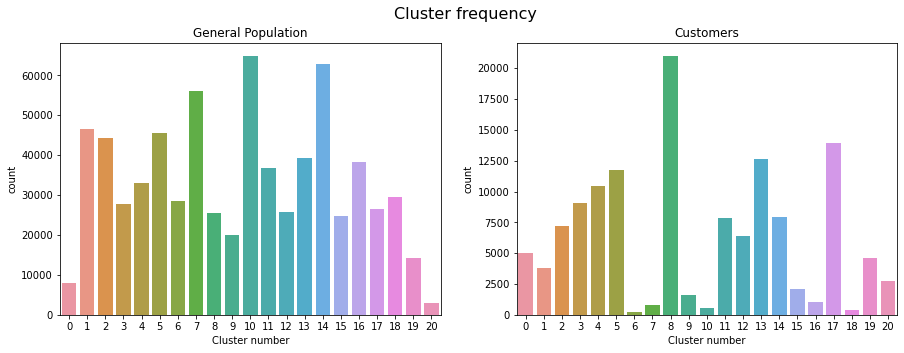

In [45]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax = plt.subplots(1,2, figsize = ((15,5)));
ax[0].set_title('General Population');
ax[1].set_title('Customers');
ax[0].set_xlabel('Cluster number');
ax[1].set_xlabel('Cluster number');
sns.countplot(ax = ax[0], x = labels);
sns.countplot(ax = ax[1], x = customers_labels);
fig.suptitle('Cluster frequency', size = 16);

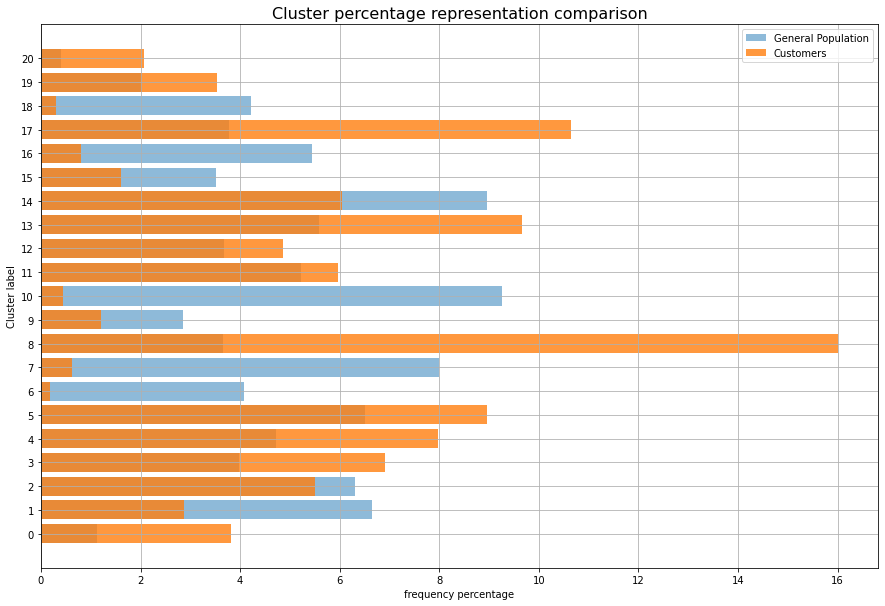

In [46]:
fig2,ax2 = plt.subplots(1,1, figsize = (15,10))
ax2.barh(np.arange(general_labels_per.shape[0]), general_labels_per, alpha = .5, label = 'General Population')
ax2.barh(np.arange(customers_labels_per.shape[0]), customers_labels_per, alpha = .8, label = 'Customers',
        tick_label = np.arange(general_labels_per.shape[0]))
ax2.legend();
ax2.set_title('Cluster percentage representation comparison', size = 16);
ax2.grid()
ax2.set_xlabel('frequency percentage');
ax2.set_ylabel('Cluster label');

In [65]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrep_cluster = Sclaer_obj.inverse_transform(pca.inverse_transform(Kmeans_obj.cluster_centers_[8]))
overrep_df = pd.DataFrame(overrep_cluster , index = customers_cleaned.columns, columns = ['Value'])
overrep_df.sort_values(by = 'Value', ascending = False).iloc[0:5]

,Value
MIN_GEBAEUDEJAHR,1993.532188
KBA13_ANZAHL_PKW,635.383646
WOHNDAUER_2008,8.373084
INNENSTADT,5.196158
SEMIO_VERT,4.864035


### Discussion: Compare Customer Data to Demographics Data

Comparing to general population, cluster 8 is underrepresented in customer dataset. For this cluster, it seems that,
the features above are the top 5 features represented by this cluster.

In [62]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrep_cluster = Sclaer_obj.inverse_transform(pca.inverse_transform(Kmeans_obj.cluster_centers_[6]))
underrep_df = pd.DataFrame(underrep_cluster , index = customers_cleaned.columns, columns = ['Value'])
underrep_df.sort_values(by = 'Value', ascending = False).iloc[0:5]

,Value
MIN_GEBAEUDEJAHR,1995.080234
KBA13_ANZAHL_PKW,674.267934
WOHNDAUER_2008,8.452305
INNENSTADT,5.083698
ONLINE_AFFINITAET,4.693237


Comparing to general population, cluster 6 is underrepresented in customer dataset. For this cluster, it seems that,
the features above are the top 5 features represented by this cluster.

<a id ='Concl'></a>
## 5- Conclusion

Real-world datasets are so complex that it might need days,months or even years from several analysts working together in order to get the best meaningful results possible. However, in this analysis we aimed to exmplify the complete pipeline involved in typical data scientist's daily life. A lot of details could be further investigated after this limited analysis in order to gain more insights about the customers and hence, more data-driven decisions. 